In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:

import math
import os
from sklearn.model_selection import train_test_split
import skimage.color as color
import numpy as np
np.set_printoptions(suppress=True)
from colors import ColorsCorpusReader
import colorsys

from transformers import pipeline
from torch_deep_neural_classifier import TorchDeepNeuralClassifier

# pipeline = pipeline('feature-extraction', model='xlnet-base-cased')
pipeline = pipeline('feature-extraction', model='gpt2')


COLORS_SRC_FILENAME = os.path.join("data", "colors", "filteredCorpus.csv")


## Class to hold target color and text

In [181]:


def return_color(rgb_c) :
    lab = color.rgb2lab(np.asarray(rgb_c ))
    lab[0] = lab[0] /100.0 * 2.0 - 1.0
    lab[1] = lab[1] /127.0
    lab[2] = lab[2] /127.0
    return lab

def represent_color_context(lab_cs):

    color_arr = np.asarray(lab_cs)
    max_arr   = np.argmax(color_arr, axis=0)   
    min_arr   = np.argmin(color_arr, axis=0) 
    # brightness offset
    # color_arr[           : ,0] =  0.0
    # color_arr[  max_arr[0] ,0] =  1.0
    # color_arr[  min_arr[0] ,0] = -1.0

    # no brightness offset
    color_arr[           : ,0] =  0.0
    color_arr[  max_arr[0] ,0] =  0.0
    color_arr[  min_arr[0] ,0] =  0.0



    return color_arr

def represent_color(lab,d_model):
    a    = np.pi
    size = d_model - 1 


    c = [ np.dot( lab , [1.0,np.cos(a*t/size),np.sin(a*t/size)] ) for t  in range(0,d_model,1) ]
    return np.array(c)

class ColorDataset() :



    def __init__(self,exs,d_model=128) :

        self.d_model = d_model
        # print(f"embedding dimension for a color :{self.d_model}")

        # turns a set of 3 rgb colors into 3 lab colors in context
        lab_colors      = lambda rgb_colors : represent_color_context( [ return_color(rgb_color) for rgb_color in rgb_colors] ) 

        # turns a set of 3 lab colors into 3 lab embeddings (each d_model dimensions)
        lab_embeddings  = lambda lab_colors : [ represent_color(lab_color,d_model) for lab_color in lab_colors ] 

        # retrieves hls colors and text list from examples
        all_hls_colors, self.texts  = zip(*[[ex.colors, ex.contents] for ex in exs])


        # llm embeddings
        self.llm_data = [ pipeline(text)  for text in self.texts ] 

        # converts hls colors to rgb colors
        all_rgb_colors            = [ [colorsys.hls_to_rgb(*color) for color in colors] for colors in all_hls_colors]

        # converts rgb colors to lab colors
        all_lab_colors            = [ lab_colors(rgb_colors) for rgb_colors in all_rgb_colors]

        # converts lab colors to lab embeddings
        self.all_lab_embeddings        = [ lab_embeddings(lab_colors) for lab_colors in all_lab_colors]

        # selects the target embedding correspnding to the target text
        self.target_embeddings           = [ lab_embeddings[2] for lab_embeddings in self.all_lab_embeddings] 

        # selects the target rgb color corresponding to the target text
        self.target_rgbs                 = [ rgb_colors[2]     for rgb_colors     in all_rgb_colors    ] 

        print(f"number of examples     :{len(self.texts)}" )


  

## Create datasets with embedding and text

- dataset.target_embeddings[0]
- dataset.target_rgbs[0]
- dataset.texts[0]

In [212]:

corpus   = ColorsCorpusReader(COLORS_SRC_FILENAME,word_count=None, normalize_colors=True)
examples = list(corpus.read())

EMB_SIZE           = 128 

far_examples  =  [ex for ex in examples if ex.condition == "far" ]
split_examples = [ex for ex in examples if ex.condition == "split" ]
close_examples = [ex for ex in examples if ex.condition == "close" ]


far_train  , far_test   = train_test_split(far_examples,train_size=.8)
close_train, close_test = train_test_split(close_examples,train_size=.8)
split_train, split_test = train_test_split(split_examples,train_size=.8)

far_train_ds, far_test_ds     = ColorDataset(far_train,d_model=EMB_SIZE) , ColorDataset(far_test,d_model=EMB_SIZE)
close_train_ds, close_test_ds = ColorDataset(split_train,d_model=EMB_SIZE),ColorDataset(close_test,d_model=EMB_SIZE) 
split_train_ds, split_test_ds = ColorDataset(close_train,d_model=EMB_SIZE), ColorDataset(split_test,d_model=EMB_SIZE) 


## Plot the first 10 color representations, along with the text that goes with it

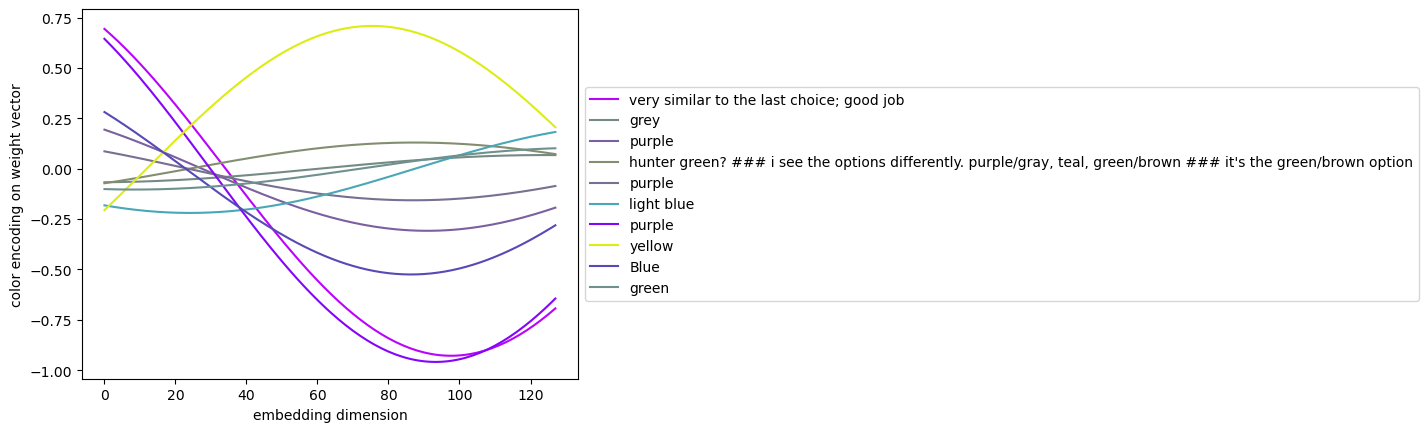

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(dataset, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(dataset.target_embeddings[i], color=dataset.target_rgbs[i], label=dataset.texts[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()

sample = (  far_train_ds.target_rgbs[0] , far_train_ds.target_embeddings[0], far_train_ds.texts[0]  )

visualize(far_train_ds,range(0,10))


## Keep only texts of length 1
- This could change to an average

In [ ]:
# # Training data
# W     = [] # words  
# X     = [] # llm embeddings
# y     = [] # color embeddings
# colors = [] # color
# for i in range(len(far_train_ds.llm_data)) :
#     x = np.asarray(far_train_ds.llm_data[i])
#     if x.shape[1]==1:
#         W.append(far_train_ds.texts[i])
#         colors.append(far_train_ds.target_rgbs[i])
#         X.append(np.squeeze(x))
#         y.append(far_train_ds.target_embeddings[i])

# X = np.asarray(X)
# y = np.asarray(y)
# print(X.shape)
# print(y.shape)

# functionalize the above so that we can use it for the test data
def get_data(dataset, word_count=1):
    W     = [] # words  
    X     = [] # llm embeddings
    y     = [] # color embeddings
    colors = [] # color
    all_colors = []
    for i in range(len(dataset.llm_data)) :
        x = np.asarray(dataset.llm_data[i])
        if x.shape[1]==word_count:
            W.append(dataset.texts[i])
            colors.append(dataset.target_rgbs[i])
            X.append(np.squeeze(x))
            y.append(dataset.target_embeddings[i])
            all_colors.append(dataset.all_lab_embeddings[i])

    X = np.asarray(X)
    y = np.asarray(y)
    all_colors = np.asarray(all_colors)
    return X,y,colors,all_colors, W

- take a look at the words

In [ ]:
print(W[0:5])


['orange', 'green', 'green', 'green', 'grey']


In [ ]:
from torch_autoencoder import TorchAutoencoder
import torch
from torch import nn

class TorchEncoder(TorchAutoencoder):
    # Can change loss function here
    def __init__(self,**base_kwargs):
        super().__init__(**base_kwargs)
        # self.loss = nn.NLLLoss()

    # can build a different model here
    def build_graph(self):
        return nn.Sequential(
            ## I changed this originally but for the sake of time I'm going to leave it as is
            nn.Linear(self.input_dim, self.hidden_dim*2),
            self.hidden_activation,
            nn.Linear(self.hidden_dim*2, self.hidden_dim),
            self.hidden_activation,
            nn.Linear(self.hidden_dim, self.output_dim))

    # minor variation from TorchAutoencoder base class so that 
    # the output dimention is y  
    def build_dataset(self, X, y=None) :
        # Data prep:
        X = np.array(X)
        self.input_dim = X.shape[1]

        # Dataset:
        X = self.convert_input_to_tensor(X)
        if y is None:
            dataset = torch.utils.data.TensorDataset(X)
        else:
            self.output_dim = y.shape[1]
            y = self.convert_input_to_tensor(y)
            dataset = torch.utils.data.TensorDataset(X, y)
        return dataset

    # the super super class does all the work ( as opposed to the TorchAutoencoder method)
    def fit(self, X, y):
        return super(TorchAutoencoder, self).fit(X,y)

wc=1
X_far, y_far, colors_far, all_colors_far, words_far = get_data(far_train_ds, word_count=wc) # far_train_ds, far_test_ds
X_far_test, y_far_test, colors_far_test, all_colors_far_test, words_far_test = get_data(far_test_ds, word_count=wc) # far_train_ds, far_test_ds

X_close, y_close, colors_close, all_colors_close, words_close = get_data(close_train_ds, word_count=wc) # close_train_ds, close_test_ds
X_close_test, y_close_test, colors_close_test, all_colors_close_test, words_close_test = get_data(close_test_ds, word_count=wc) # close_train_ds, close_test_ds

X_split, y_split, colors_split, all_colors_split, words_split = get_data(split_train_ds, word_count=wc) # split_train_ds, split_test_ds
X_split_test, y_split_test, colors_split_test, all_colors_split_test, words_split_test = get_data(split_test_ds, word_count=wc) # split_train_ds, split_test_ds

In [ ]:
def get_accuracy(model, X, y, w):
    # using the model to predict the color embedding, 
    # compute the correlation between the predicted color embedding and the true color embedding
    # based upon the highest correlation, return the index of the color
    # calculate the accuracy
    y_pred = model.predict(X)
    index_results = []
    for i in range(len(y_pred)):
        array_corrs = [np.corrcoef(y_pred[i], y[i][j]).mean() for j in range(3)]
        # return the index of the highest correlation
        max_corr = np.argmax(array_corrs)
        index_results.append(max_corr)

    # return a list containing a tuple of the predicted color and output of the prediction
    # return [(w[i], index_results[i]) for i in range(len(index_results))]
    result = [1 if i == 2 else 0 for i in index_results]
    prediction_results = [(w[i], index_results[i]) for i in range(len(index_results))]
    accuracy = sum(result) / len(index_results)
    return prediction_results, accuracy

Stopping after epoch 36. Training loss did not improve more than tol=1e-05. Final error is 0.1868078913539648.

far accuracy:  0.35327635327635326


In [ ]:
far_mod = TorchEncoder(hidden_dim=EMB_SIZE*2 )
far_mod.fit(X_far, y_far)
print("far accuracy: ", get_accuracy(far_mod, X_far_test, all_colors_far, words_far_test)[1])

close_mod = TorchEncoder(hidden_dim=EMB_SIZE*2 )
close_mod.fit(X_close, y_close)
print("close accuracy: ", get_accuracy(close_mod, X_close_test, all_colors_close, words_close_test)[1])

split_mod = TorchEncoder(hidden_dim=EMB_SIZE*2 )
split_mod.fit(X_split, y_split)
print("split accuracy: ", get_accuracy(split_mod, X_split_test, all_colors_split, words_split_test)[1])

In [211]:
far_res, far_acc = get_accuracy(far_mod, X_far_test, all_colors_far, words_far_test)
close_res, close_acc = get_accuracy(close_mod, X_close_test, all_colors_close, words_close_test)
split_res, split_acc = get_accuracy(split_mod, X_split_test, all_colors_split, words_split_test)

# concatenate the results into a single dataframe and calculate the accuracy grouped by the dataset and the color
results = pd.DataFrame(far_res + close_res + split_res, columns=['word', 'color'])
results['dataset'] = ['far']*len(far_res) + ['close']*len(close_res) + ['split']*len(split_res)
results['correct'] = results['color'] == 2
results.groupby(['dataset', 'word']).mean()

0.35327635327635326

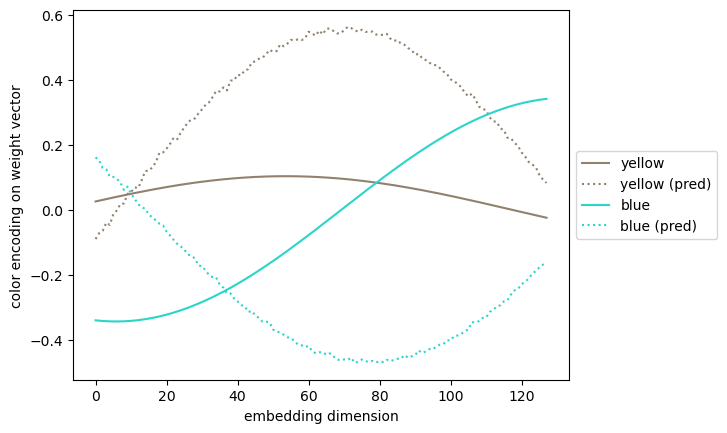

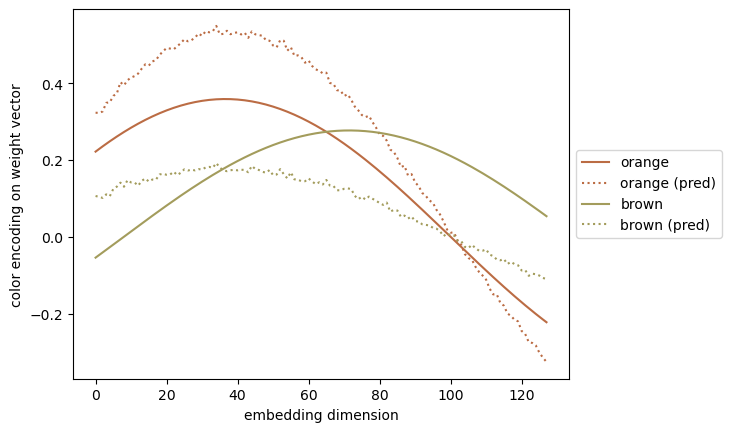

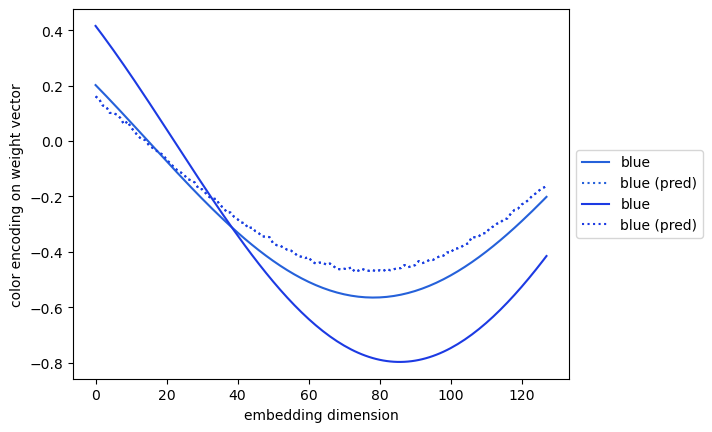

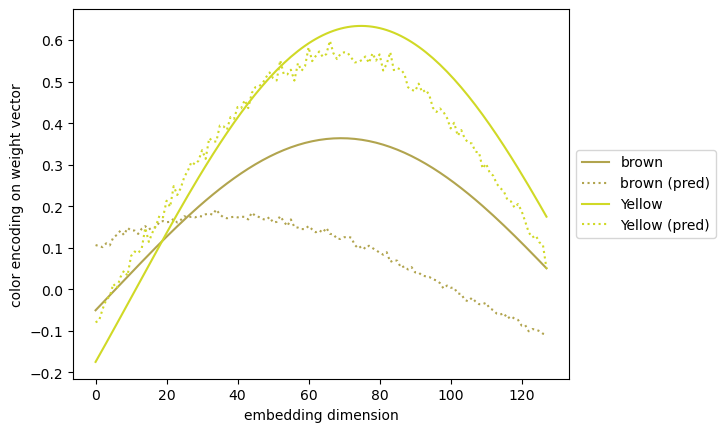

In [11]:
def plot(W,color,y,y_pred, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(y[i],  color=color[i], label=W[i])
        ax.plot(y_pred[i], linestyle='dotted', color=color[i],label=W[i]+ " (pred)")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()

sample = (  far_train_ds.target_rgbs[0] , far_train_ds.target_embeddings[0], far_train_ds.texts[0]  )

plot(W,colors,y,y_pred,range(0,2))
plot(W,colors,y,y_pred,range(2,4))
plot(W,colors,y,y_pred,range(4,6))
plot(W,colors,y,y_pred,range(6,8))